# Snowflake Arctic Tutorial With PCA   
@Author: Zoumana KEITA     

https://www.linkedin.com/in/zoumana-keita/


In [1]:
!nvidia-smi

Fri May 17 18:14:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   54C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
%%bash
pip -qqq install transformers>=4.39.0
pip -qqq install torch

In [4]:
import torch
from transformers import AutoTokenizer, AutoModel
from torch.nn.functional import cosine_similarity

In [6]:
model_checkpoint = "Snowflake/snowflake-arctic-embed-xs"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModel.from_pretrained(model_checkpoint, add_pooling_layer=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [20]:
def generate_embedding(document):
    inputs = tokenizer(document, padding=True, truncation=True,
                       return_tensors='pt', max_length=512)

    embedding = model(**inputs)[0][:, 0]
    return embedding

In [25]:
def find_similar_documents(query_document, document_embeddings, top_n=5):

    query_embedding = generate_embedding(query_document)

    similarity_scores = [cosine_similarity(query_embedding,
                                           doc_embedding).item() for doc_embedding in document_embeddings]

    sorted_indices = torch.argsort(torch.tensor(similarity_scores),
                                   descending=True)

    top_documents = [documents[idx] for idx in sorted_indices[:top_n]]
    top_scores = [similarity_scores[idx] for idx in sorted_indices[:top_n]]

    return top_documents, top_scores

In [22]:
# Sample documents
documents = [
    "This is a tutorial about Snowflake Arctic Embedding models",
    "Arctic-embed is a state-of-the-art text embedding model.",
    "Snowflake provides various cloud data warehousing solutions.",
    "Embedding models are used for representing text as dense vectors.",
    "The Arctic-embed model is based on the transformer architecture."
]

In [23]:
document_embeddings = [generate_embedding(doc) for doc in documents]

In [27]:
query_document = "What is the Arctic-embed model?"
top_documents, top_scores = find_similar_documents(query_document, document_embeddings)

In [11]:
print("Query Document:")
print(query_document)
print("\nTop Similar Documents:")
for doc, score in zip(top_documents, top_scores):
    print(f"Document: {doc}")
    print(f"Similarity Score: {score:.4f}")
    print()

Query Document:
What is the Arctic-embed model?

Top Similar Documents:
Document: Arctic-embed is a state-of-the-art text embedding model.
Similarity Score: 0.9499

Document: The Arctic-embed model is based on the transformer architecture.
Similarity Score: 0.9357

Document: This is a tutorial about Snowflake Arctic Embedding models
Similarity Score: 0.9015

Document: Embedding models are used for representing text as dense vectors.
Similarity Score: 0.8377

Document: Snowflake provides various cloud data warehousing solutions.
Similarity Score: 0.7366



## Visualiation of the documents

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

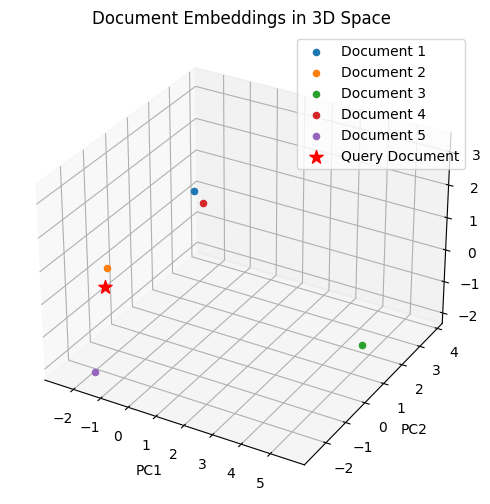

In [19]:
# Update the find similar documents function

def find_similar_documents(query_document, documents, top_n=5):
    query_embedding = generate_embedding(query_document)
    document_embeddings = [generate_embedding(doc) for doc in documents]

    similarity_scores = [cosine_similarity(query_embedding, doc_embedding).item() for doc_embedding in document_embeddings]
    sorted_indices = torch.argsort(torch.tensor(similarity_scores), descending=True)

    top_documents = [documents[idx] for idx in sorted_indices[:top_n]]
    top_scores = [similarity_scores[idx] for idx in sorted_indices[:top_n]]

    return top_documents, top_scores, document_embeddings


#query_document = "What is the Arctic-embed model?"
top_documents, top_scores, document_embeddings = find_similar_documents(query_document, documents)

# Reshape the embeddings
reshaped_embeddings = torch.stack(document_embeddings).detach().numpy()
reshaped_embeddings = reshaped_embeddings.reshape(reshaped_embeddings.shape[0], -1)

# Apply PCA to reduce the embeddings to 3 dimensions
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(reshaped_embeddings)

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the document embeddings
for i, doc in enumerate(documents):
    ax.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2], marker='o', label=f"Document {i+1}")

# Plot the query document embedding
query_embedding = generate_embedding(query_document)
reshaped_query_embedding = query_embedding.detach().numpy().reshape(1, -1)
reduced_query_embedding = pca.transform(reshaped_query_embedding)
ax.scatter(reduced_query_embedding[0, 0], reduced_query_embedding[0, 1],
           reduced_query_embedding[0, 2], marker='*', s=100, color='red',
           label="Query Document")

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.title('Document Embeddings in 3D Space')
plt.show()

## Streamlit application with full code  

Make sure to paste the following code in a Python (app.py) file and run with the following command:

```
python run app.py
```

In [5]:
%%bash
pip -qqq install streamlit
pip -qqq install pyngrok

In [9]:
import streamlit as st
from pyngrok import ngrok

In [6]:

# Streamlit app
st.title("Document Similarity Search Using Snowflake Arctic")

query_document = st.text_input("Enter your query document:")
top_k = st.number_input("Enter the number of top documents to retrieve (K):", min_value=1, value=3, step=1)

if st.button("Search"):
    top_documents, top_scores, document_embeddings = find_similar_documents(query_document, documents, top_n=top_k)

    st.subheader("Top {} Similar Documents:".format(top_k))
    for i, (doc, score) in enumerate(zip(top_documents, top_scores)):
        st.write("{}. Document: {}".format(i+1, doc))
        st.write("   Similarity Score: {:.4f}".format(score))

    # Reshape the embeddings
    reshaped_embeddings = torch.stack(document_embeddings).detach().numpy()
    reshaped_embeddings = reshaped_embeddings.reshape(reshaped_embeddings.shape[0], -1)

    # Apply PCA to reduce the embeddings to 3 dimensions
    pca = PCA(n_components=3)
    reduced_embeddings = pca.fit_transform(reshaped_embeddings)

    # Create a 3D plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the document embeddings
    for i, doc in enumerate(documents):
        ax.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2], marker='o', label=f"Document {i+1}")

    # Plot the query document embedding
    query_embedding = generate_embedding(query_document)
    reshaped_query_embedding = query_embedding.detach().numpy().reshape(1, -1)
    reduced_query_embedding = pca.transform(reshaped_query_embedding)
    ax.scatter(reduced_query_embedding[0, 0], reduced_query_embedding[0, 1], reduced_query_embedding[0, 2], marker='*', s=100, color='red', label="Query Document")

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()
    plt.title('Document Embeddings in 3D Space')

    st.pyplot(fig)